In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

In [5]:
# 파일 불러오기
train_combat = pd.read_csv('./train_combat.csv')
train_label = pd.read_csv('./train_label_add.csv')
train_activity = pd.read_csv('./train_activity.csv')
train_payment = pd.read_csv('./train_payment.csv')

# 40000명으로 압축한 데이터셋
data3 = train_combat.groupby('acc_id').sum().drop(['char_id','level','class','day'],axis=1).reset_index()
data2 = train_activity.groupby('acc_id').sum().drop(['char_id','day'],axis=1).reset_index()
data1 = pd.merge(data2, data3, on ='acc_id')

In [45]:
# 모든 변수는 40000행 데이터셋에 맞춰서 merge 됩니다. 
def std(x): return np.std(x)

def num_combat(train_combat, data):
    num_combat = train_combat[['acc_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 전투기록이 있으면 1, 아니면 0
    num_combat['pledge_cnt'] = np.where(train_combat['pledge_cnt']>0, 1,0)
    num_combat['random_attacker_cnt'] = np.where(train_combat['random_attacker_cnt']>0, 1,0)
    num_combat['random_defender_cnt'] = np.where(train_combat['random_defender_cnt']>0, 1,0)
    num_combat['temp_cnt'] = np.where(train_combat['temp_cnt']>0, 1,0)
    num_combat['same_pledge_cnt'] = np.where(train_combat['same_pledge_cnt']>0, 1,0)
    num_combat['etc_cnt'] = np.where(train_combat['etc_cnt']>0, 1,0)

    # 합산 및 컬럼명 변경
    num_combat = num_combat.groupby('acc_id').sum().reset_index()

    num_combat.rename(columns={'pledge_cnt':'day_pledge', 'random_attacker_cnt':'day_attack', 'random_defender_cnt':'day_defend', 
                           'temp_cnt':'day_temp', 'same_pledge_cnt':'day_same', 'etc_cnt':'day_etc'},inplace=True)
    data2 = pd.merge(data, num_combat, on = 'acc_id')
    return data2

# 6. 레벨이 올랐는가?
# 의문점: 고렙 유저와 저렙 유저에 차이가 있어서 가중치를 줘야하나?
def deff_level(train_combat,data):    
    # 관련 컬럼 불러오기
    level =  train_combat[['acc_id','char_id','day','level']]
    # 캐릭터별 max 레벨과 min 레벨 생성
    level_max = level.groupby(['acc_id','char_id']).max().reset_index()
    level_min = level.groupby(['acc_id','char_id']).min().reset_index()
    # 레벨 데이터를  acc_id,char_id 단위 그룹으로 재정의(day 압축)
    level = level.groupby(['acc_id','char_id']).sum().reset_index()
    # max, min 컬럼 추가
    level['max'] = level_max['level']
    level['min'] = level_min['level']
    # 차이 계산
    level['deff_level'] = level['max'] - level['min']
    # acc_id로 그룹화 후, 필요 없는 컬럼 제거
    level = level.groupby(['acc_id']).sum().reset_index().drop(['max','min','day','level','char_id'],axis=1)
    # deff_level 추가
    data2 = pd.merge(data, level, on = 'acc_id')
    return data2

# 5. 캐릭터별 각 전투 변수의 28일 간 표준편차 (접속한 날만 대상으로 표준편차 구함)
def std_combat(train_combat,data):
    std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    # 케릭터 별로 28일의 표준편차 구하고, day 없애고, 모든 값이 0이고 1행인 애들이 NaN이 나옴
    # 1안: 접속 안한 날은 전투시간 =0인 날로 간주하고 n=28로 분산 계산한다
    # 2안: 접속일수를 분모로 분산을 계산한다.
    # 3안: 유저 단위로 합쳐서 1,2안 중 하나를 계산한다
    # 4안: 다 해본다.
    
    std_combat = std_combat.groupby(['acc_id','char_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    std_combat.rename(columns={'pledge_cnt':'std_pledge', 'random_attacker_cnt':'std_attack', 'random_defender_cnt':'std_defend', 
                           'temp_cnt':'std_temp', 'same_pledge_cnt':'std_same', 'etc_cnt':'std_etc'},inplace=True)
    
    # 일단 캐릭터별 표준편차를 유저 단위로 합함
    std_combat = std_combat.groupby('acc_id').sum().reset_index().drop('char_id',axis=1)
    data2 = pd.merge(data, std_combat, on = ['acc_id'])
    return data2

# 유저별 각 전투 변수의 28일 간 표준편차(접속한 날만 대상으로 표준편차 구함)
def acc_std_combat(train_combat,data):
    acc_std_combat = train_combat[['acc_id','day','char_id','pledge_cnt','random_attacker_cnt', 'random_defender_cnt', 'temp_cnt',
       'same_pledge_cnt', 'etc_cnt']]
    
    acc_std_combat = acc_std_combat.groupby(['acc_id']).agg(std).reset_index().drop('day',axis=1).fillna(0)
    acc_std_combat.rename(columns={'pledge_cnt':'acc_std_pledge', 'random_attacker_cnt':'acc_std_attack', 'random_defender_cnt':'acc_std_defend', 
                           'temp_cnt':'acc_std_temp', 'same_pledge_cnt':'acc_std_same', 'etc_cnt':'acc_std_etc'},inplace=True)
    
    acc_std_combat = acc_std_combat.drop('char_id',axis=1)
    data2 = pd.merge(data, acc_std_combat, on = ['acc_id'])
    return data2


# 총 사용 캐릭터 개수(char_count), 총 접속일수(day_count)     
def char_day_count(train_combat,data):    
    char_count = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_count = char_count.reset_index()
    char_count = char_count.groupby('acc_id').count()
    char_count = char_count.reset_index()
    char_count.rename(columns={'day':'day_count','char_id':'char_count'},inplace=True)
    data2 = pd.merge(data, char_count, on = ['acc_id'])
    return data2

# 보유한 캐릭터 개수
def char_max(train_combat,data):
    char_max = train_combat.groupby(['day','acc_id'])['char_id'].count()
    char_max = char_max.reset_index()
    char_max = char_max.groupby('acc_id').max()
    char_max = char_max.reset_index().drop('day',axis=1)
    char_max.rename(columns={'char_id':'char_max'},inplace=True)
    data2 = pd.merge(data, char_max, on = ['acc_id'])
    return data2

# 사용자 최고 레벨
def level_max(train_combat,data):
    level_max = train_combat[['acc_id','level']]
    level_max = level_max.groupby('acc_id').max()
    level_max = level_max.reset_index()
    level_max.rename(columns={'level':'level_max'},inplace=True)
    data2 = pd.merge(data, level_max, on = 'acc_id')
    return data2

# 클래스를 무과금 가능 클래스(저렙과 엮으면 시너지?) vS 무과금 힘든 클래스, pk 유리 클래스 vs pk 약한 클래스

# 접속일자 단순 합(범위: 1~406)
def day_sum(train_combat, data):
    day_sum = train_combat[['day','acc_id','char_id']]
    day_sum = day_sum.groupby(['day','acc_id']).sum().reset_index()
    day_sum = day_sum.groupby(['acc_id']).sum().reset_index()
    day_sum = day_sum.drop('char_id',axis=1) 
    day_sum.rename(columns={'day':'day_sum'},inplace=True)

    data2 = pd.merge(data, day_sum, on='acc_id')
    return data2

# day_sum을 28로 나눔
def day_28(train_combat, data):
    day_28 = train_combat[['day','acc_id','char_id']].groupby(['day','acc_id']).sum().reset_index()
    day_28 = day_28.groupby(['acc_id']).sum().reset_index()
    day_28 = day_28.drop('char_id',axis=1) 
    day_28.rename(columns={'day':'day_28'},inplace=True)
    day_28['day_28'] = day_28['day_28'] / 28

    data2 = pd.merge(data, day_28, on='acc_id')
    return data2

# 각 클래스별로 사용 횟수를 다 더해서 비교하면 의미가 있을까??
# 날짜가 들어가는 건 의미가 없을 것 같고, 전체 캐릭터 중에서 어떤 클래스를 복수로 운영하는지를 보는 게 좋을 것 같다.
def class_count(train_combat, data):
    class_dum =pd.get_dummies(train_combat['class'], prefix="C")
    combat_dum = pd.concat([train_combat[['day','acc_id','char_id']], class_dum], axis=1)
    combat_dum = combat_dum.groupby(['day','acc_id']).sum().reset_index().drop('char_id',axis=1)
    combat_dum = combat_dum.groupby(['acc_id']).max().reset_index().drop('day',axis=1)
    
    data2 = pd.merge(data, combat_dum, on='acc_id')
    return data2
## 추가할 요소
# 전투(혹은 막피)로 인해 죽은 횟수
# 레벨에 따른 레벨 변화 가중치 매기기 + 레벨업 속도 가중치 매기기
# 접속일수 기준 평균 플레이타임

In [277]:
# 모든 변수 추가
data = num_combat(train_combat, data1)
data = std_combat(train_combat, data)
data = acc_std_combat(train_combat, data)

data = deff_level(train_combat, data)
data = level_max(train_combat, data)
data = char_day_count(train_combat, data)
data = char_max(train_combat, data)
data = day_sum(train_combat, data)

data = day_28(train_combat, data) # 타겟에 있어서 day_sum과 같은 상관관계가 나옴

# day_mean : day_sum / 접속일수
data['day_mean'] = data['day_sum'] / data['day_count'] # day_sum보다 타겟이랑 상관 떨어짐

# 장사꾼 유저
data['merchant'] = np.where((data1['npc_kill']==0) & (data1['solo_exp']==0) & (data1['party_exp']==0) &
                                         (data1['rich_monster']==0) & (data1['death']==0) & (data1['fishing']==0) &
                                         (data1['pledge_cnt']==0) & (data1['random_attacker_cnt']==0) & (data1['random_defender_cnt']==0) & 
                                         (data1['temp_cnt']==0) & (data1['same_pledge_cnt']==0) & (data1['etc_cnt']==0) & 
                                         (data1['private_shop']>0), 1, 0)

C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\samsung\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [292]:
# 변수 추가한 파일 저장
data.to_csv('feature_add_0817.csv')

In [286]:
data_label = pd.merge(data, train_label, on= 'acc_id').drop('Unnamed: 0',axis=1)

### 상관관계 보기 

In [290]:
# 추가 변수와의 상관관계만 보기
corr_matrix = data_label.loc[:,'merchant':'total_spent'].corr()
corr_matrix['total_spent'].sort_values(ascending=False)

total_spent       1.000000
day_pledge        0.325001
survival_time     0.279657
amount_spent      0.266910
std_pledge        0.265491
acc_std_pledge    0.260840
level_max         0.257999
day_temp          0.241448
day_etc           0.220762
day_same          0.202078
char_max          0.187417
acc_std_same      0.148484
std_same          0.138213
day_sum           0.126468
day_28            0.126468
day_count         0.122277
char_count        0.122277
day_attack        0.112668
std_etc           0.099554
std_attack        0.095370
acc_std_etc       0.095223
acc_std_attack    0.095142
deff_level        0.045141
std_temp          0.026353
acc_std_temp      0.010644
day_defend       -0.004165
std_defend       -0.025615
acc_std_defend   -0.031072
day_mean         -0.085891
merchant         -0.166620
secession        -0.266477
Name: total_spent, dtype: float64

In [175]:
corr_matrix = data_label.corr()
corr_matrix['day_sum'].sort_values(ascending=False)

day_28                 1.000000
day_sum                1.000000
day_count              0.974149
char_count             0.974149
playtime               0.553639
survival_time          0.453908
npc_kill               0.335992
day_etc                0.293026
day_temp               0.277633
rich_monster           0.256774
day_defend             0.206309
private_shop           0.206256
fishing                0.186838
merchant               0.166172
day_pledge             0.161481
num_opponent           0.141943
random_defender_cnt    0.135581
total_spent            0.126468
etc_cnt                0.119093
std_defend             0.116899
level_max              0.115278
std_pledge             0.113419
acc_std_pledge         0.109694
day_same               0.106593
acc_std_defend         0.105689
amount_spent_x         0.104771
death                  0.099892
pledge_cnt             0.099487
std_etc                0.095952
acc_std_etc            0.088571
revive                 0.087554
same_ple

In [50]:
data = pd.read_csv('./feature_add_0817.csv')

In [51]:
train_payment = train_payment.groupby('acc_id').sum().reset_index()
data = pd.merge(data,train_payment, on='acc_id',how='outer').fillna(0)

In [52]:
data = class_count(train_combat,data)

In [54]:
data_label = pd.merge(data, train_label, on= 'acc_id')

In [59]:
corr_matrix = data_label.corr()
corr_matrix['C_0'].sort_values(ascending=False)
# c_7이 돈이 들어가는 편인 듯?

C_0                    1.000000
char_max               0.474541
C_2                    0.122248
C_7                    0.096426
C_3                    0.091922
rich_monster           0.087244
C_1                    0.083355
deff_level             0.074746
C_6                    0.071165
day_temp               0.070910
level_max              0.069819
quest_exp              0.068281
fishing                0.063617
C_4                    0.061111
total_spent            0.056222
C_5                    0.047757
std_attack             0.045215
day                    0.044696
solo_exp               0.039995
survival_time          0.038200
amount_spent_x         0.037431
day_28                 0.027475
day_sum                0.027475
day_attack             0.025914
char_count             0.025669
day_count              0.025669
std_same               0.025509
day_same               0.024026
std_temp               0.023925
same_pledge_cnt        0.020929
                         ...   
acc_std_

# 이런저런 실험

survival_time          1.000000
day_28                 0.706605
day_sum                0.706605
day_count              0.683545
char_count             0.683545
playtime               0.626321
private_shop           0.540312
merchant               0.348848
char_max               0.181939
day_temp               0.175390
std_temp               0.157835
amount_spent_x         0.146518
temp_cnt               0.135322
day                    0.112151
std_same               0.090205
acc_std_same           0.090205
acc_std_temp           0.077650
total_spent            0.069737
acc_id                 0.062969
Unnamed: 0_x           0.062812
fishing                0.038084
deff_level             0.025149
day_attack             0.023628
random_attacker_cnt    0.023628
acc_std_attack         0.023628
std_attack             0.023628
day_pledge             0.019510
pledge_cnt             0.019510
same_pledge_cnt        0.017762
day_same               0.017762
Unnamed: 0_y           0.016806
std_defe

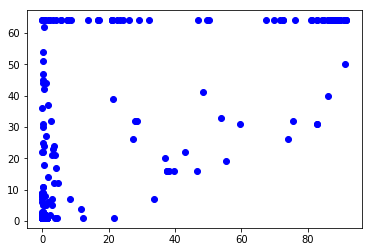

In [131]:
datal = data_label[(data_label['level_max']>=7) & (data_label['level_max']<=9)]
#datal = data_label[(data_label['level_max']==14)]
datal.describe().T
plt.plot(datal['playtime'], datal['survival_time'],'bo')
corr_matrix = datal.corr()
corr_matrix['survival_time'].sort_values(ascending=False)

In [132]:
import matplotlib.pyplot as plt
datal = data_label[(data_label['level_max']>=10) & (data_label['level_max']<=11)]
#datal = data_label[(data_label['level_max']==14)]
datal.describe().T
#plt.plot(datal['solo_exp'], datal['survival_time'],'bo')
corr_matrix = datal.corr()
corr_matrix['survival_time'].sort_values(ascending=False)

survival_time          1.000000
day_sum                0.675904
day_28                 0.675904
day_count              0.668908
char_count             0.668908
playtime               0.628117
private_shop           0.538653
merchant               0.302497
Unnamed: 0_y           0.193450
total_spent            0.185851
day_temp               0.138384
temp_cnt               0.110711
std_temp               0.083043
char_max               0.077183
amount_spent_x         0.057433
day                    0.036095
acc_std_temp           0.004468
std_same              -0.011502
enchant_count         -0.019704
game_money_change     -0.024142
acc_std_attack        -0.026493
pledge_cnt            -0.029876
day_defend            -0.035147
std_attack            -0.035284
random_attacker_cnt   -0.037155
fishing               -0.039659
day_same              -0.040061
same_pledge_cnt       -0.043562
random_defender_cnt   -0.043759
acc_std_same          -0.043865
std_pledge            -0.044520
acc_std_

In [133]:
import matplotlib.pyplot as plt
datal = data_label[(data_label['level_max']>=12) & (data_label['level_max']<=14)]
#datal = data_label[(data_label['level_max']==14)]
datal.describe().T
#plt.plot(datal['solo_exp'], datal['survival_time'],'bo')
corr_matrix = datal.corr()
corr_matrix['survival_time'].sort_values(ascending=False)

survival_time          1.000000
day_28                 0.288350
day_sum                0.288350
total_spent            0.270640
char_count             0.244714
day_count              0.244714
private_shop           0.243066
playtime               0.220792
merchant               0.152478
day_temp               0.138736
amount_spent_x         0.077862
solo_exp               0.076461
temp_cnt               0.063926
char_max               0.056923
rich_monster           0.050855
std_temp               0.044482
day_pledge             0.043404
num_opponent           0.040526
day_same               0.039513
acc_std_temp           0.039291
day_attack             0.038018
deff_level             0.036174
std_etc                0.035991
etc_cnt                0.035736
npc_kill               0.034958
acc_std_etc            0.034009
acc_std_attack         0.033393
std_same               0.033105
level_max              0.033032
quest_exp              0.031920
random_attacker_cnt    0.028146
std_atta

In [137]:
datal = data_label[(data_label['level_max']>=15) & (data_label['level_max']<=16)]
#datal = data_label[(data_label['level_max']==14)]
datal.describe().T
#plt.plot(datal['solo_exp'], datal['survival_time'],'bo')
#corr_matrix = datal.corr()
#corr_matrix['survival_time'].sort_values(ascending=False)

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0_x,21122.0,19986.749077,11582.654273,1.000000,9951.500000,20009.500000,30052.500000,39998.000000
acc_id,21122.0,65240.581952,37641.718152,5.000000,32641.000000,65392.000000,97837.500000,130470.000000
playtime,21122.0,36.752080,29.622865,0.002341,11.783444,27.095425,64.857801,91.655377
npc_kill,21122.0,22.426617,19.942274,0.000000,7.968290,18.576568,31.244421,157.242517
solo_exp,21122.0,12.728445,20.375516,0.000000,0.385744,1.732907,17.944240,208.369237
party_exp,21122.0,6.706194,24.086569,0.000000,0.000000,0.026630,1.034666,300.769341
quest_exp,21122.0,4.645673,10.398722,0.000000,0.020605,0.118737,2.119743,140.199035
rich_monster,21122.0,5.501610,7.217162,0.000000,0.000000,3.000000,9.000000,99.000000
death,21122.0,3.123868,10.520741,0.000000,0.245883,0.983534,2.950602,615.938081
revive,21122.0,2.638303,10.371971,0.000000,0.000000,0.494674,2.226032,619.084253


In [77]:
import matplotlib.pyplot as plt
datal = data_label[(data_label['deff_level']<13)]
#datal = data_label[(data_label['deff_level']>=15) & (data_label['deff_level']<=40)]
print(datal['playtime'].mean())
#datal.describe().T
plt.plot(data_label['playtime'], data_label['solo_exp'],'bo')
corr_matrix = data_label.corr()
corr_matrix['deff_level'].sort_values(ascending=False)
# deff_lavel이 높을수록 퀘스트 경험치가 비율이 높고 솔로 경험치는 적다(deff 15 기준으로 비교)

42.53339146075199


deff_level             1.000000
solo_exp               0.583344
quest_exp              0.516760
char_max               0.221895
day                    0.220508
rich_monster           0.215675
amount_spent_x         0.201443
C_5                    0.176545
std_etc                0.161569
day_temp               0.159727
level_max              0.152439
C_2                    0.147247
exp_recovery           0.144682
day_etc                0.143873
C_3                    0.141072
C_4                    0.138275
C_6                    0.138094
party_exp              0.136673
C_7                    0.124680
std_same               0.113607
secession              0.105616
std_attack             0.091568
day_same               0.087621
day_attack             0.080466
same_pledge_cnt        0.077411
C_0                    0.074746
acc_std_same           0.074281
acc_std_etc            0.071507
std_temp               0.068548
day_sum                0.060019
                         ...   
death   

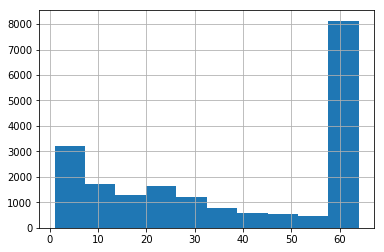

In [168]:
data_label[data_label['day_sum']<=400]['survival_time'].hist()

In [60]:
data_label =data_label.drop(['Unnamed: 0_x','Unnamed: 0_y'],axis=1) 

In [66]:
train = data_label.drop(['acc_id','total_spent','survival_time',
                         'amount_spent_y','secession','playtime', 'npc_kill', 'solo_exp',
       'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
       'exp_recovery', 'fishing', 'private_shop', 'game_money_change'],axis=1) 

In [67]:
train.head()

,enchant_count,pledge_cnt,random_attacker_cnt,random_defender_cnt,temp_cnt,same_pledge_cnt,etc_cnt,num_opponent,merchant,day_pledge,...,day,amount_spent_x,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,...,0.0,0.000000,0,1,0,0,0,0,0,0
1,0.0,0.000000,0.000000,0.000000,0.479728,0.000000,0.000000,0.098129,0,0,...,0.0,0.000000,0,0,3,0,0,0,0,0
2,0.0,0.128368,4.270875,1.183064,3.837822,0.000000,0.900892,3.041991,0,2,...,27.0,1.404644,0,1,1,1,1,1,1,1
3,0.0,0.000000,0.000000,2.366129,3.358094,12.398273,0.675669,1.373803,0,0,...,0.0,0.000000,1,3,0,0,0,0,0,0
4,0.0,1.283685,0.000000,1.183064,0.479728,0.000000,16.441283,10.107262,0,7,...,43.0,0.896531,0,0,0,0,2,0,0,1


In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=19)
train1 = pca.fit(train).transform(train)
sum(pca.explained_variance_ratio_)

0.9993261255217574

In [74]:
train1.shape

(40000, 19)

In [75]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#data_new = data_label.drop(['Unnamed: 0_x','Unnamed: 0_y','playtime', 'npc_kill', 'solo_exp',
#       'party_exp', 'quest_exp', 'rich_monster', 'death', 'revive',
#       'exp_recovery', 'fishing', 'private_shop', 'game_money_change',
#       'enchant_count', 'pledge_cnt', 'random_attacker_cnt',
#       'random_defender_cnt', 'temp_cnt', 'same_pledge_cnt', 'etc_cnt',
#       'num_opponent','amount_spent_x','day_28','day_count','char_count'],axis=1)

# 이탈자 분류를 위한 샘플링
from sklearn.model_selection import train_test_split
#data4 = data_new.drop(['acc_id','amount_spent_y', 'survival_time', 'total_spent'],axis=1)
#train_set = data4.drop('secession', axis=1)
target = data_label['secession']
train_x, test_x, train_y, test_y = train_test_split(train1,target,test_size=0.3, random_state=42 )

rnd_clf = RandomForestClassifier(n_estimators=700,random_state=42)
rnd_clf.fit(train_x,train_y)
y_pred = rnd_clf.predict(test_x)
print(rnd_clf.__class__.__name__, accuracy_score(test_y, y_pred))
print(rnd_clf.__class__.__name__, f1_score(test_y, y_pred)) 

RandomForestClassifier 0.7330833333333333
RandomForestClassifier 0.692344635481702


In [81]:
data[data['char_max']==228]

,Unnamed: 0,acc_id,playtime,npc_kill,solo_exp,party_exp,quest_exp,rich_monster,death,revive,...,day,amount_spent,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7
36627,36627,119439,23.607849,19.45555,11.20508,0.0,21.269994,0,0.491767,0.494674,...,62.0,0.383725,0,227,0,1,0,0,0,1


In [1]:
data.info()

NameError: name 'data' is not defined